In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=20.6s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load gene annotation

In [5]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [6]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Null gene set

In [7]:
np.random.seed(0)
gs_size_list = [20, 100, 500]
n_rep=100
dic_nullset= {}

md.compute_stats(data_facs_ct)
df_gene = pd.DataFrame(index=data_facs_ct.var_names)
df_gene['mean'] = data_facs_ct.var['mean'].values
df_gene['std'] = np.sqrt(data_facs_ct.var['var'].values)
df_gene['cv'] = df_gene['std'].values/df_gene['mean'].values
df_gene['var'] = data_facs_ct.var['var'].values
df_gene['var_tech'] = data_facs_ct.var['var_tech'].values
df_gene = df_gene.sort_values(by=['mean'])

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        ind_select = np.random.permutation(data_facs_ct.shape[1])[:n_gene]
        gs_name = 'all_size%d;rep%d'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(data_facs_ct.var_names[ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        # Select lowly- and highly- expressed random genes 
        ind_select = np.random.permutation(5000)[:n_gene]
        gs_name = 'lowexp_size%d;rep%d'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(df_gene.index[:5000][ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))

for n_gene in gs_size_list:
    for i_rep in np.arange(n_rep):
        ind_select = np.random.permutation(5000)[:n_gene]
        gs_name = 'highexp_size%d;rep%d'%(n_gene,i_rep)
        dic_nullset[gs_name] =  list(df_gene.index[-5000:][ind_select])
        print('# %-20s n_gene=%-3d mean=%0.2e std=%0.2e'
              %(gs_name, len(dic_nullset[gs_name]),
                df_gene.loc[dic_nullset[gs_name],'mean'].mean(),
                df_gene.loc[dic_nullset[gs_name],'mean'].std()))


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


# all_size20;rep0      n_gene=20  mean=8.21e-02 std=1.12e-01
# all_size20;rep1      n_gene=20  mean=1.18e-01 std=2.10e-01
# all_size20;rep2      n_gene=20  mean=1.07e-01 std=1.45e-01
# all_size20;rep3      n_gene=20  mean=1.16e-01 std=1.49e-01
# all_size20;rep4      n_gene=20  mean=5.27e-02 std=6.10e-02
# all_size20;rep5      n_gene=20  mean=9.67e-02 std=1.93e-01
# all_size20;rep6      n_gene=20  mean=1.51e-01 std=3.18e-01
# all_size20;rep7      n_gene=20  mean=7.55e-02 std=9.46e-02
# all_size20;rep8      n_gene=20  mean=5.16e-02 std=8.07e-02
# all_size20;rep9      n_gene=20  mean=5.88e-02 std=8.39e-02
# all_size20;rep10     n_gene=20  mean=1.36e-01 std=2.24e-01
# all_size20;rep11     n_gene=20  mean=6.33e-02 std=1.09e-01
# all_size20;rep12     n_gene=20  mean=1.57e-01 std=2.14e-01
# all_size20;rep13     n_gene=20  mean=6.93e-02 std=7.90e-02
# all_size20;rep14     n_gene=20  mean=7.98e-02 std=1.58e-01
# all_size20;rep15     n_gene=20  mean=1.53e-01 std=2.52e-01
# all_size20;rep16     n

# all_size100;rep55    n_gene=100 mean=1.36e-01 std=2.25e-01
# all_size100;rep56    n_gene=100 mean=9.40e-02 std=1.44e-01
# all_size100;rep57    n_gene=100 mean=1.15e-01 std=2.30e-01
# all_size100;rep58    n_gene=100 mean=1.08e-01 std=1.81e-01
# all_size100;rep59    n_gene=100 mean=8.32e-02 std=1.29e-01
# all_size100;rep60    n_gene=100 mean=8.40e-02 std=1.24e-01
# all_size100;rep61    n_gene=100 mean=7.91e-02 std=1.80e-01
# all_size100;rep62    n_gene=100 mean=7.52e-02 std=1.91e-01
# all_size100;rep63    n_gene=100 mean=1.00e-01 std=2.63e-01
# all_size100;rep64    n_gene=100 mean=1.21e-01 std=1.99e-01
# all_size100;rep65    n_gene=100 mean=9.72e-02 std=1.92e-01
# all_size100;rep66    n_gene=100 mean=1.03e-01 std=2.10e-01
# all_size100;rep67    n_gene=100 mean=1.06e-01 std=1.82e-01
# all_size100;rep68    n_gene=100 mean=9.09e-02 std=1.84e-01
# all_size100;rep69    n_gene=100 mean=8.65e-02 std=1.66e-01
# all_size100;rep70    n_gene=100 mean=1.12e-01 std=1.90e-01
# all_size100;rep71    n

# lowexp_size20;rep42  n_gene=20  mean=1.99e-04 std=1.79e-04
# lowexp_size20;rep43  n_gene=20  mean=2.30e-04 std=2.17e-04
# lowexp_size20;rep44  n_gene=20  mean=2.55e-04 std=2.14e-04
# lowexp_size20;rep45  n_gene=20  mean=1.88e-04 std=1.76e-04
# lowexp_size20;rep46  n_gene=20  mean=2.09e-04 std=2.10e-04
# lowexp_size20;rep47  n_gene=20  mean=1.82e-04 std=1.47e-04
# lowexp_size20;rep48  n_gene=20  mean=2.48e-04 std=2.17e-04
# lowexp_size20;rep49  n_gene=20  mean=2.45e-04 std=2.39e-04
# lowexp_size20;rep50  n_gene=20  mean=1.71e-04 std=1.33e-04
# lowexp_size20;rep51  n_gene=20  mean=2.18e-04 std=2.23e-04
# lowexp_size20;rep52  n_gene=20  mean=1.95e-04 std=1.97e-04
# lowexp_size20;rep53  n_gene=20  mean=2.11e-04 std=1.71e-04
# lowexp_size20;rep54  n_gene=20  mean=2.88e-04 std=2.13e-04
# lowexp_size20;rep55  n_gene=20  mean=2.63e-04 std=2.28e-04
# lowexp_size20;rep56  n_gene=20  mean=1.59e-04 std=1.90e-04
# lowexp_size20;rep57  n_gene=20  mean=2.02e-04 std=1.88e-04
# lowexp_size20;rep58  n

# lowexp_size500;rep16 n_gene=500 mean=2.33e-04 std=2.08e-04
# lowexp_size500;rep17 n_gene=500 mean=2.50e-04 std=2.10e-04
# lowexp_size500;rep18 n_gene=500 mean=2.19e-04 std=2.03e-04
# lowexp_size500;rep19 n_gene=500 mean=2.32e-04 std=2.05e-04
# lowexp_size500;rep20 n_gene=500 mean=2.12e-04 std=1.92e-04
# lowexp_size500;rep21 n_gene=500 mean=2.30e-04 std=2.13e-04
# lowexp_size500;rep22 n_gene=500 mean=2.13e-04 std=1.99e-04
# lowexp_size500;rep23 n_gene=500 mean=2.21e-04 std=2.04e-04
# lowexp_size500;rep24 n_gene=500 mean=2.41e-04 std=2.16e-04
# lowexp_size500;rep25 n_gene=500 mean=2.35e-04 std=2.09e-04
# lowexp_size500;rep26 n_gene=500 mean=2.43e-04 std=2.12e-04
# lowexp_size500;rep27 n_gene=500 mean=2.20e-04 std=2.02e-04
# lowexp_size500;rep28 n_gene=500 mean=2.17e-04 std=1.95e-04
# lowexp_size500;rep29 n_gene=500 mean=2.33e-04 std=2.04e-04
# lowexp_size500;rep30 n_gene=500 mean=2.32e-04 std=2.07e-04
# lowexp_size500;rep31 n_gene=500 mean=2.36e-04 std=2.08e-04
# lowexp_size500;rep32 n

# highexp_size20;rep69 n_gene=20  mean=3.30e-01 std=2.15e-01
# highexp_size20;rep70 n_gene=20  mean=3.59e-01 std=3.05e-01
# highexp_size20;rep71 n_gene=20  mean=2.85e-01 std=1.85e-01
# highexp_size20;rep72 n_gene=20  mean=4.06e-01 std=3.07e-01
# highexp_size20;rep73 n_gene=20  mean=2.95e-01 std=1.65e-01
# highexp_size20;rep74 n_gene=20  mean=2.74e-01 std=1.32e-01
# highexp_size20;rep75 n_gene=20  mean=2.13e-01 std=8.07e-02
# highexp_size20;rep76 n_gene=20  mean=3.59e-01 std=1.74e-01
# highexp_size20;rep77 n_gene=20  mean=3.48e-01 std=2.98e-01
# highexp_size20;rep78 n_gene=20  mean=4.16e-01 std=3.12e-01
# highexp_size20;rep79 n_gene=20  mean=4.61e-01 std=3.68e-01
# highexp_size20;rep80 n_gene=20  mean=3.62e-01 std=2.65e-01
# highexp_size20;rep81 n_gene=20  mean=4.08e-01 std=4.00e-01
# highexp_size20;rep82 n_gene=20  mean=3.13e-01 std=2.56e-01
# highexp_size20;rep83 n_gene=20  mean=3.21e-01 std=2.10e-01
# highexp_size20;rep84 n_gene=20  mean=4.24e-01 std=3.56e-01
# highexp_size20;rep85 n

# highexp_size500;rep33 n_gene=500 mean=3.45e-01 std=4.33e-01
# highexp_size500;rep34 n_gene=500 mean=3.52e-01 std=4.68e-01
# highexp_size500;rep35 n_gene=500 mean=3.51e-01 std=3.70e-01
# highexp_size500;rep36 n_gene=500 mean=3.58e-01 std=3.32e-01
# highexp_size500;rep37 n_gene=500 mean=3.32e-01 std=2.66e-01
# highexp_size500;rep38 n_gene=500 mean=3.21e-01 std=2.52e-01
# highexp_size500;rep39 n_gene=500 mean=3.33e-01 std=3.23e-01
# highexp_size500;rep40 n_gene=500 mean=3.47e-01 std=2.86e-01
# highexp_size500;rep41 n_gene=500 mean=3.66e-01 std=3.34e-01
# highexp_size500;rep42 n_gene=500 mean=3.36e-01 std=2.60e-01
# highexp_size500;rep43 n_gene=500 mean=3.61e-01 std=3.23e-01
# highexp_size500;rep44 n_gene=500 mean=3.46e-01 std=2.85e-01
# highexp_size500;rep45 n_gene=500 mean=3.21e-01 std=2.43e-01
# highexp_size500;rep46 n_gene=500 mean=3.58e-01 std=4.30e-01
# highexp_size500;rep47 n_gene=500 mean=3.57e-01 std=3.12e-01
# highexp_size500;rep48 n_gene=500 mean=3.48e-01 std=2.76e-01
# highex

### Test TRS

In [8]:
# Precompute mean and var 
md.compute_stats(data_facs_ct)

In [9]:
# Obtain TRS: This takes a lot of time.
from itertools import product
null_trait_list = list(dic_nullset.keys())
start_time = time.time()
dic_trs={}

md_list = [['mean_match', 'mean', 'empi'],
           ['mean_match', 'mean', 'recipe_vision'],
           ['mean_match', 'mean', None],
           ['mean_match', 'vst', 'empi'],
           ['mean_match', 'vst', 'recipe_vision'],
           ['mean_match', 'vst', None],
           ['mean_match', 'inv_std', 'empi'],
           ['mean_match', 'inv_std', 'recipe_vision'],
           ['mean_match', 'inv_std', None]]

for trait in null_trait_list:
    for ctrl_opt,trs_opt,bc_opt in md_list:
        term='%s;ctrl_opt=%s,trs_opt=%s,bc_opt=%s'%(trait,ctrl_opt,trs_opt,bc_opt)
        md.score_cell(data_facs_ct, dic_nullset[trait], suffix='', 
                      ctrl_opt=ctrl_opt, trs_opt=trs_opt, bc_opt=bc_opt,
                      n_ctrl=1, n_genebin=200, 
                      return_list=['trs_tp','trs_ep'], verbose=False)
        dic_trs[term] = data_facs_ct.obs['trs_ep'].values.copy()
        dic_trs['%s;trs_opt=%s,tp'%(trait,trs_opt)] = data_facs_ct.obs['trs_tp'].values.copy()
        print('# %-50s time=%0.1fs'%(term,time.time()-start_time))

# all_size20;rep0;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1.7s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=3.1s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=4.5s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=6.1s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=7.5s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=8.9s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=10.6s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=12.0s
# all_size20;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=13.4s
# all_size20;rep1;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=15.0s
# all_size20;rep1;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=16.4s
# all_size20;rep1;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=17.9s
# all_size20;rep1;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=19.5s
# a

# all_size20;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=159.8s
# all_size20;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=161.2s
# all_size20;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=162.6s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=164.3s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=165.7s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=167.1s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=168.8s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=170.2s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=171.6s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=173.3s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=174.7s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=176.2s
# all_size20;rep13;ctrl_opt=mean_matc

# all_size20;rep23;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=321.2s
# all_size20;rep23;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=322.6s
# all_size20;rep23;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=324.2s
# all_size20;rep23;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=325.7s
# all_size20;rep23;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=327.4s
# all_size20;rep23;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=329.0s
# all_size20;rep23;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=330.4s
# all_size20;rep23;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=331.9s
# all_size20;rep24;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=333.5s
# all_size20;rep24;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=334.9s
# all_size20;rep24;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=336.6s
# all_size20;rep24;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=338.3s
# all_size20;rep24;ctrl_opt=mean_match,trs_opt=

# all_size20;rep34;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=479.4s
# all_size20;rep34;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=481.0s
# all_size20;rep34;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=482.4s
# all_size20;rep34;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=483.8s
# all_size20;rep35;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=485.5s
# all_size20;rep35;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=486.9s
# all_size20;rep35;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=488.3s
# all_size20;rep35;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=490.0s
# all_size20;rep35;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=491.4s
# all_size20;rep35;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=492.9s
# all_size20;rep35;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=494.5s
# all_size20;rep35;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=495.9s
# all_size20;rep35;ctrl_opt=mean_match,tr

# all_size20;rep46;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=633.9s
# all_size20;rep46;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=635.3s
# all_size20;rep46;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=636.7s
# all_size20;rep46;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=638.3s
# all_size20;rep46;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=639.7s
# all_size20;rep46;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=641.1s
# all_size20;rep46;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=642.7s
# all_size20;rep46;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=644.1s
# all_size20;rep46;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=645.6s
# all_size20;rep47;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=647.2s
# all_size20;rep47;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=648.6s
# all_size20;rep47;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=650.0s
# all_size20;rep47;ctrl_opt=mean_match,trs_opt

# all_size20;rep57;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=786.6s
# all_size20;rep57;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=788.0s
# all_size20;rep57;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=789.6s
# all_size20;rep57;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=791.0s
# all_size20;rep57;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=792.4s
# all_size20;rep58;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=794.0s
# all_size20;rep58;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=795.4s
# all_size20;rep58;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=796.8s
# all_size20;rep58;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=798.4s
# all_size20;rep58;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=799.8s
# all_size20;rep58;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=801.2s
# all_size20;rep58;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=802.9s
# all_size20;rep58;ctrl_opt=mean_match,trs_op

# all_size20;rep68;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=939.3s
# all_size20;rep69;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=941.0s
# all_size20;rep69;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=942.4s
# all_size20;rep69;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=943.8s
# all_size20;rep69;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=945.5s
# all_size20;rep69;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=946.9s
# all_size20;rep69;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=948.4s
# all_size20;rep69;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=950.1s
# all_size20;rep69;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=951.5s
# all_size20;rep69;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=952.9s
# all_size20;rep70;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=954.6s
# all_size20;rep70;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=956.0s
# all_size20;rep70;ctrl_opt=mean_match,trs_

# all_size20;rep80;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1092.2s
# all_size20;rep80;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1093.7s
# all_size20;rep80;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1095.1s
# all_size20;rep80;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1096.7s
# all_size20;rep80;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1098.2s
# all_size20;rep80;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1099.6s
# all_size20;rep81;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1101.2s
# all_size20;rep81;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1102.6s
# all_size20;rep81;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1104.0s
# all_size20;rep81;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1105.6s
# all_size20;rep81;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1107.0s
# all_size20;rep81;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1108.4s
# all_size20;rep81;ctrl_opt=mean_matc

# all_size20;rep91;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1243.5s
# all_size20;rep91;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1244.9s
# all_size20;rep91;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1246.3s
# all_size20;rep92;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1247.9s
# all_size20;rep92;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1249.3s
# all_size20;rep92;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1250.7s
# all_size20;rep92;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1252.3s
# all_size20;rep92;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1253.6s
# all_size20;rep92;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1255.0s
# all_size20;rep92;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1256.6s
# all_size20;rep92;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1258.0s
# all_size20;rep92;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1259.4s
# all_size20;rep93;ctrl_o

# all_size100;rep3;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1398.4s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1399.9s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1401.4s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1403.2s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1404.7s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1406.2s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1408.0s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1409.5s
# all_size100;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1411.0s
# all_size100;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1412.8s
# all_size100;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1414.3s
# all_size100;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1415.8s
# all_size100;rep4;ctrl_opt=mean_m

# all_size100;rep14;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1562.3s
# all_size100;rep14;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1563.8s
# all_size100;rep14;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1565.3s
# all_size100;rep14;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1567.1s
# all_size100;rep14;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1568.6s
# all_size100;rep14;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1570.1s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1571.9s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1573.4s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1574.9s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1576.6s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1578.1s
# all_size100;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1579.6s
# all_size100;rep15;ctrl_

# all_size100;rep25;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1724.3s
# all_size100;rep25;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1726.0s
# all_size100;rep25;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1727.6s
# all_size100;rep25;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1729.1s
# all_size100;rep26;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1730.9s
# all_size100;rep26;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1732.4s
# all_size100;rep26;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1734.0s
# all_size100;rep26;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1735.7s
# all_size100;rep26;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1737.3s
# all_size100;rep26;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1738.8s
# all_size100;rep26;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1740.5s
# all_size100;rep26;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1742.1s
# all_size100;rep

# all_size100;rep36;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1886.7s
# all_size100;rep36;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1888.2s
# all_size100;rep37;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1890.0s
# all_size100;rep37;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=1891.5s
# all_size100;rep37;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=1893.0s
# all_size100;rep37;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=1894.7s
# all_size100;rep37;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=1896.2s
# all_size100;rep37;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=1897.8s
# all_size100;rep37;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=1899.5s
# all_size100;rep37;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=1901.0s
# all_size100;rep37;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=1902.5s
# all_size100;rep38;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=1904.3s
# all_size100;re

# all_size100;rep48;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2049.1s
# all_size100;rep48;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2050.6s
# all_size100;rep48;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2052.1s
# all_size100;rep48;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2053.8s
# all_size100;rep48;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2055.3s
# all_size100;rep48;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2056.8s
# all_size100;rep48;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2058.6s
# all_size100;rep48;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2060.1s
# all_size100;rep48;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2061.6s
# all_size100;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2063.3s
# all_size100;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2064.9s
# all_size100;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2066.4s
# all_size100;rep49;ct

# all_size100;rep59;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2211.1s
# all_size100;rep59;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2212.9s
# all_size100;rep59;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2214.4s
# all_size100;rep59;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2215.9s
# all_size100;rep59;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2217.7s
# all_size100;rep59;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2219.2s
# all_size100;rep59;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2220.7s
# all_size100;rep60;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2222.5s
# all_size100;rep60;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2224.0s
# all_size100;rep60;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2225.5s
# all_size100;rep60;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2227.3s
# all_size100;rep60;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2228.8s
# all_size100;rep60;ctrl

# all_size100;rep70;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2373.3s
# all_size100;rep70;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2374.9s
# all_size100;rep70;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2376.6s
# all_size100;rep70;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2378.2s
# all_size100;rep70;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2379.7s
# all_size100;rep71;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2381.5s
# all_size100;rep71;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2383.0s
# all_size100;rep71;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2384.6s
# all_size100;rep71;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2386.3s
# all_size100;rep71;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2387.9s
# all_size100;rep71;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2389.5s
# all_size100;rep71;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2391.3s
# all_size100;rep71;c

# all_size100;rep81;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2536.0s
# all_size100;rep81;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2537.5s
# all_size100;rep81;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2539.1s
# all_size100;rep82;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2540.8s
# all_size100;rep82;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2542.4s
# all_size100;rep82;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2543.9s
# all_size100;rep82;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2545.7s
# all_size100;rep82;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2547.2s
# all_size100;rep82;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2548.8s
# all_size100;rep82;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2550.5s
# all_size100;rep82;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2552.1s
# all_size100;rep82;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2553.6s
# all_size100

# all_size100;rep92;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2698.0s
# all_size100;rep93;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2699.8s
# all_size100;rep93;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2701.3s
# all_size100;rep93;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2702.8s
# all_size100;rep93;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2704.6s
# all_size100;rep93;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2706.1s
# all_size100;rep93;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2707.6s
# all_size100;rep93;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2709.4s
# all_size100;rep93;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2710.9s
# all_size100;rep93;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2712.4s
# all_size100;rep94;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2714.2s
# all_size100;rep94;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2715.7s
# all_size100;rep94

# all_size500;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2870.0s
# all_size500;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2871.8s
# all_size500;rep4;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2873.8s
# all_size500;rep4;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=2875.6s
# all_size500;rep4;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=2877.4s
# all_size500;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=2879.4s
# all_size500;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=2881.2s
# all_size500;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=2883.0s
# all_size500;rep5;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=2885.0s
# all_size500;rep5;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=2886.8s
# all_size500;rep5;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=2888.6s
# all_size500;rep5;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=2890.6s
# all_size500;rep5;ctrl_opt=mean_ma

# all_size500;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=3058.3s
# all_size500;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=3060.1s
# all_size500;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=3061.9s
# all_size500;rep15;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=3063.9s
# all_size500;rep15;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=3065.6s
# all_size500;rep15;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=3067.4s
# all_size500;rep16;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=3069.4s
# all_size500;rep16;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=3071.2s
# all_size500;rep16;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=3073.0s
# all_size500;rep16;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=3075.0s
# all_size500;rep16;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=3076.8s
# all_size500;rep16;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=3078.6s
# all_size500;rep16;ctrl_

# all_size500;rep26;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=3246.2s
# all_size500;rep26;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=3248.2s
# all_size500;rep26;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=3249.9s
# all_size500;rep26;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=3251.7s
# all_size500;rep27;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=3253.7s
# all_size500;rep27;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=3255.5s
# all_size500;rep27;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=3257.3s
# all_size500;rep27;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=3259.3s
# all_size500;rep27;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=3261.1s
# all_size500;rep27;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=3263.0s
# all_size500;rep27;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=3264.9s
# all_size500;rep27;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=3266.7s
# all_size500;rep

# all_size500;rep37;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=3434.7s
# all_size500;rep37;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=3436.5s
# all_size500;rep38;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=3438.5s
# all_size500;rep38;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=3440.3s
# all_size500;rep38;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=3442.1s
# all_size500;rep38;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=3444.1s
# all_size500;rep38;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=3445.9s
# all_size500;rep38;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=3447.7s
# all_size500;rep38;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=3449.7s
# all_size500;rep38;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=3451.5s
# all_size500;rep38;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=3453.2s
# all_size500;rep39;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=3455.2s
# all_size500;re

# all_size500;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=3622.6s
# all_size500;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=3624.4s
# all_size500;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=3626.2s
# all_size500;rep49;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=3628.2s
# all_size500;rep49;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=3630.0s
# all_size500;rep49;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=3631.8s
# all_size500;rep49;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=3633.8s
# all_size500;rep49;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=3635.6s
# all_size500;rep49;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=3637.3s
# all_size500;rep50;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=3639.3s
# all_size500;rep50;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=3641.1s
# all_size500;rep50;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=3643.0s
# all_size500;rep50;ct

# all_size500;rep60;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=3810.6s
# all_size500;rep60;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=3812.6s
# all_size500;rep60;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=3814.4s
# all_size500;rep60;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=3816.2s
# all_size500;rep60;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=3818.2s
# all_size500;rep60;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=3820.0s
# all_size500;rep60;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=3821.7s
# all_size500;rep61;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=3823.8s
# all_size500;rep61;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=3825.5s
# all_size500;rep61;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=3827.3s
# all_size500;rep61;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=3829.4s
# all_size500;rep61;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=3831.2s
# all_size500;rep61;ctrl

# all_size500;rep71;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=3998.9s
# all_size500;rep71;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=4000.8s
# all_size500;rep71;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=4002.8s
# all_size500;rep71;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=4004.5s
# all_size500;rep71;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=4006.3s
# all_size500;rep72;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4008.3s
# all_size500;rep72;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=4010.1s
# all_size500;rep72;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=4011.9s
# all_size500;rep72;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=4013.9s
# all_size500;rep72;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=4015.7s
# all_size500;rep72;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=4017.5s
# all_size500;rep72;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=4019.5s
# all_size500;rep72;c

# all_size500;rep82;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=4187.2s
# all_size500;rep82;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=4189.0s
# all_size500;rep82;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=4190.7s
# all_size500;rep83;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4192.8s
# all_size500;rep83;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=4194.5s
# all_size500;rep83;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=4196.3s
# all_size500;rep83;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=4198.3s
# all_size500;rep83;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=4200.1s
# all_size500;rep83;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=4201.9s
# all_size500;rep83;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=4203.9s
# all_size500;rep83;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=4205.7s
# all_size500;rep83;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=4207.4s
# all_size500

# all_size500;rep93;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=4374.8s
# all_size500;rep94;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4376.9s
# all_size500;rep94;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=4378.7s
# all_size500;rep94;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=4380.5s
# all_size500;rep94;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=4382.5s
# all_size500;rep94;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=4384.3s
# all_size500;rep94;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=4386.1s
# all_size500;rep94;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=4388.0s
# all_size500;rep94;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=4389.8s
# all_size500;rep94;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=4391.6s
# all_size500;rep95;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4393.6s
# all_size500;rep95;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=4395.4s
# all_size500;rep95

# lowexp_size20;rep5;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4541.4s
# lowexp_size20;rep5;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=4542.7s
# lowexp_size20;rep5;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=4544.1s
# lowexp_size20;rep5;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=4545.7s
# lowexp_size20;rep5;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=4547.0s
# lowexp_size20;rep5;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=4548.4s
# lowexp_size20;rep5;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=4550.0s
# lowexp_size20;rep5;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=4551.3s
# lowexp_size20;rep5;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=4552.7s
# lowexp_size20;rep6;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4554.2s
# lowexp_size20;rep6;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=4555.6s
# lowexp_size20;rep6;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=4557.0s
# lowexp_s

# lowexp_size20;rep16;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4683.1s
# lowexp_size20;rep16;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=4684.4s
# lowexp_size20;rep16;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=4685.8s
# lowexp_size20;rep16;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=4687.4s
# lowexp_size20;rep16;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=4688.7s
# lowexp_size20;rep16;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=4690.1s
# lowexp_size20;rep16;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=4691.6s
# lowexp_size20;rep16;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=4693.0s
# lowexp_size20;rep16;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=4694.4s
# lowexp_size20;rep17;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4695.9s
# lowexp_size20;rep17;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=4697.3s
# lowexp_size20;rep17;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=4698.6

# lowexp_size20;rep26;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=4823.2s
# lowexp_size20;rep27;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4824.8s
# lowexp_size20;rep27;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=4826.1s
# lowexp_size20;rep27;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=4827.5s
# lowexp_size20;rep27;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=4829.1s
# lowexp_size20;rep27;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=4830.4s
# lowexp_size20;rep27;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=4831.8s
# lowexp_size20;rep27;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=4833.4s
# lowexp_size20;rep27;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=4834.7s
# lowexp_size20;rep27;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=4836.1s
# lowexp_size20;rep28;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4837.7s
# lowexp_size20;rep28;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=483

# lowexp_size20;rep37;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=4965.1s
# lowexp_size20;rep38;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4966.6s
# lowexp_size20;rep38;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=4968.0s
# lowexp_size20;rep38;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=4969.3s
# lowexp_size20;rep38;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=4970.9s
# lowexp_size20;rep38;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=4972.3s
# lowexp_size20;rep38;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=4973.6s
# lowexp_size20;rep38;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=4975.2s
# lowexp_size20;rep38;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=4976.6s
# lowexp_size20;rep38;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=4977.9s
# lowexp_size20;rep39;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=4979.5s
# lowexp_size20;rep39;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=498

# lowexp_size20;rep48;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5106.9s
# lowexp_size20;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5108.5s
# lowexp_size20;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=5109.9s
# lowexp_size20;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=5111.2s
# lowexp_size20;rep49;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=5112.8s
# lowexp_size20;rep49;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=5114.1s
# lowexp_size20;rep49;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=5115.5s
# lowexp_size20;rep49;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=5117.1s
# lowexp_size20;rep49;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=5118.4s
# lowexp_size20;rep49;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5119.8s
# lowexp_size20;rep50;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5121.4s
# lowexp_size20;rep50;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=512

# lowexp_size20;rep59;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5248.7s
# lowexp_size20;rep60;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5250.3s
# lowexp_size20;rep60;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=5251.6s
# lowexp_size20;rep60;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=5253.0s
# lowexp_size20;rep60;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=5254.6s
# lowexp_size20;rep60;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=5255.9s
# lowexp_size20;rep60;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=5257.3s
# lowexp_size20;rep60;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=5258.9s
# lowexp_size20;rep60;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=5260.2s
# lowexp_size20;rep60;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5261.6s
# lowexp_size20;rep61;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5263.2s
# lowexp_size20;rep61;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=526

# lowexp_size20;rep70;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5390.5s
# lowexp_size20;rep71;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5392.0s
# lowexp_size20;rep71;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=5393.4s
# lowexp_size20;rep71;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=5394.8s
# lowexp_size20;rep71;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=5396.3s
# lowexp_size20;rep71;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=5397.7s
# lowexp_size20;rep71;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=5399.0s
# lowexp_size20;rep71;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=5400.6s
# lowexp_size20;rep71;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=5402.0s
# lowexp_size20;rep71;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5403.3s
# lowexp_size20;rep72;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5404.9s
# lowexp_size20;rep72;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=540

# lowexp_size20;rep81;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5532.1s
# lowexp_size20;rep82;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5533.7s
# lowexp_size20;rep82;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=5535.0s
# lowexp_size20;rep82;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=5536.4s
# lowexp_size20;rep82;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=5538.0s
# lowexp_size20;rep82;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=5539.3s
# lowexp_size20;rep82;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=5540.7s
# lowexp_size20;rep82;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=5542.3s
# lowexp_size20;rep82;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=5543.6s
# lowexp_size20;rep82;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5545.0s
# lowexp_size20;rep83;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5546.5s
# lowexp_size20;rep83;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=554

# lowexp_size20;rep92;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5673.8s
# lowexp_size20;rep93;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5675.4s
# lowexp_size20;rep93;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=5676.7s
# lowexp_size20;rep93;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=5678.1s
# lowexp_size20;rep93;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=5679.7s
# lowexp_size20;rep93;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=5681.0s
# lowexp_size20;rep93;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=5682.4s
# lowexp_size20;rep93;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=5684.0s
# lowexp_size20;rep93;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=5685.3s
# lowexp_size20;rep93;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5686.7s
# lowexp_size20;rep94;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5688.3s
# lowexp_size20;rep94;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=568

# lowexp_size100;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5815.6s
# lowexp_size100;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5817.1s
# lowexp_size100;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=5818.5s
# lowexp_size100;rep4;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=5819.9s
# lowexp_size100;rep4;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=5821.5s
# lowexp_size100;rep4;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=5822.8s
# lowexp_size100;rep4;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=5824.2s
# lowexp_size100;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=5825.8s
# lowexp_size100;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=5827.1s
# lowexp_size100;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5828.5s
# lowexp_size100;rep5;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5830.1s
# lowexp_size100;rep5;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=583

# lowexp_size100;rep14;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=5956.6s
# lowexp_size100;rep14;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5958.0s
# lowexp_size100;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=5959.6s
# lowexp_size100;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=5960.9s
# lowexp_size100;rep15;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=5962.3s
# lowexp_size100;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=5963.9s
# lowexp_size100;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=5965.2s
# lowexp_size100;rep15;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=5966.6s
# lowexp_size100;rep15;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=5968.2s
# lowexp_size100;rep15;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=5969.5s
# lowexp_size100;rep15;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=5970.9s
# lowexp_size100;rep16;ctrl_opt=mean_match,trs_opt=mean,bc_op

# lowexp_size100;rep25;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=6095.7s
# lowexp_size100;rep25;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=6097.3s
# lowexp_size100;rep25;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=6098.6s
# lowexp_size100;rep25;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=6100.0s
# lowexp_size100;rep26;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=6101.6s
# lowexp_size100;rep26;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=6102.9s
# lowexp_size100;rep26;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=6104.3s
# lowexp_size100;rep26;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=6105.9s
# lowexp_size100;rep26;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=6107.3s
# lowexp_size100;rep26;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=6108.6s
# lowexp_size100;rep26;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=6110.2s
# lowexp_size100;rep26;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_v

# lowexp_size100;rep36;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=6235.0s
# lowexp_size100;rep36;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=6236.4s
# lowexp_size100;rep36;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=6237.7s
# lowexp_size100;rep36;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=6239.3s
# lowexp_size100;rep36;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=6240.7s
# lowexp_size100;rep36;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=6242.0s
# lowexp_size100;rep37;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=6243.6s
# lowexp_size100;rep37;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=6245.0s
# lowexp_size100;rep37;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=6246.3s
# lowexp_size100;rep37;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=6247.9s
# lowexp_size100;rep37;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=6249.3s
# lowexp_size100;rep37;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None ti

# lowexp_size100;rep47;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=6374.2s
# lowexp_size100;rep47;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=6375.5s
# lowexp_size100;rep47;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=6377.1s
# lowexp_size100;rep47;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=6378.5s
# lowexp_size100;rep47;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=6379.8s
# lowexp_size100;rep47;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=6381.4s
# lowexp_size100;rep47;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=6382.8s
# lowexp_size100;rep47;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=6384.1s
# lowexp_size100;rep48;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=6385.7s
# lowexp_size100;rep48;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=6387.1s
# lowexp_size100;rep48;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=6388.4s
# lowexp_size100;rep48;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi 

# lowexp_size100;rep57;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=6513.2s
# lowexp_size100;rep58;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=6514.8s
# lowexp_size100;rep58;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=6516.2s
# lowexp_size100;rep58;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=6517.5s
# lowexp_size100;rep58;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=6519.1s
# lowexp_size100;rep58;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=6520.5s
# lowexp_size100;rep58;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=6521.8s
# lowexp_size100;rep58;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=6523.4s
# lowexp_size100;rep58;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=6524.8s
# lowexp_size100;rep58;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=6526.2s
# lowexp_size100;rep59;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=6527.8s
# lowexp_size100;rep59;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vis

# lowexp_size100;rep68;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=6652.7s
# lowexp_size100;rep68;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=6654.0s
# lowexp_size100;rep68;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=6655.4s
# lowexp_size100;rep69;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=6657.0s
# lowexp_size100;rep69;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=6658.3s
# lowexp_size100;rep69;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=6659.7s
# lowexp_size100;rep69;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=6661.3s
# lowexp_size100;rep69;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=6662.6s
# lowexp_size100;rep69;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=6664.0s
# lowexp_size100;rep69;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=6665.6s
# lowexp_size100;rep69;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=6666.9s
# lowexp_size100;rep69;ctrl_opt=mean_match,trs_opt=inv_std,bc

# lowexp_size100;rep79;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=6791.8s
# lowexp_size100;rep79;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=6793.2s
# lowexp_size100;rep79;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=6794.8s
# lowexp_size100;rep79;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=6796.1s
# lowexp_size100;rep79;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=6797.5s
# lowexp_size100;rep80;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=6799.1s
# lowexp_size100;rep80;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=6800.4s
# lowexp_size100;rep80;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=6801.8s
# lowexp_size100;rep80;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=6803.4s
# lowexp_size100;rep80;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=6804.7s
# lowexp_size100;rep80;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=6806.1s
# lowexp_size100;rep80;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=emp

# lowexp_size100;rep90;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=6931.6s
# lowexp_size100;rep90;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=6933.2s
# lowexp_size100;rep90;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=6934.6s
# lowexp_size100;rep90;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=6936.0s
# lowexp_size100;rep90;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=6937.6s
# lowexp_size100;rep90;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=6938.9s
# lowexp_size100;rep90;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=6940.3s
# lowexp_size100;rep91;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=6941.9s
# lowexp_size100;rep91;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=6943.3s
# lowexp_size100;rep91;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=6944.7s
# lowexp_size100;rep91;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=6946.3s
# lowexp_size100;rep91;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision t

# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=7072.4s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=7073.8s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=7075.2s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=7076.8s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=7078.2s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=7079.6s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=7081.2s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=7082.6s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=7084.0s
# lowexp_size500;rep2;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=7085.6s
# lowexp_size500;rep2;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=7087.0s
# lowexp_size500;rep2;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=7088.4

# lowexp_size500;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=7215.3s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=7216.9s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=7218.2s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=7219.6s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=7221.3s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=7222.7s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=7224.0s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=7225.6s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=7227.0s
# lowexp_size500;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=7228.4s
# lowexp_size500;rep13;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=7230.0s
# lowexp_size500;rep13;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vis

# lowexp_size500;rep22;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=7355.8s
# lowexp_size500;rep22;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=7357.2s
# lowexp_size500;rep22;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=7358.6s
# lowexp_size500;rep23;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=7360.2s
# lowexp_size500;rep23;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=7361.5s
# lowexp_size500;rep23;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=7362.9s
# lowexp_size500;rep23;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=7364.5s
# lowexp_size500;rep23;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=7365.9s
# lowexp_size500;rep23;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=7367.2s
# lowexp_size500;rep23;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=7368.8s
# lowexp_size500;rep23;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=7370.2s
# lowexp_size500;rep23;ctrl_opt=mean_match,trs_opt=inv_std,bc

# lowexp_size500;rep33;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=7496.1s
# lowexp_size500;rep33;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=7497.5s
# lowexp_size500;rep33;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=7499.1s
# lowexp_size500;rep33;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=7500.4s
# lowexp_size500;rep33;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=7501.8s
# lowexp_size500;rep34;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=7503.4s
# lowexp_size500;rep34;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=7504.8s
# lowexp_size500;rep34;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=7506.2s
# lowexp_size500;rep34;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=7507.7s
# lowexp_size500;rep34;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=7509.1s
# lowexp_size500;rep34;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=7510.5s
# lowexp_size500;rep34;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=emp

# lowexp_size500;rep44;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=7636.5s
# lowexp_size500;rep44;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=7638.1s
# lowexp_size500;rep44;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=7639.4s
# lowexp_size500;rep44;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=7640.8s
# lowexp_size500;rep44;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=7642.4s
# lowexp_size500;rep44;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=7643.8s
# lowexp_size500;rep44;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=7645.2s
# lowexp_size500;rep45;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=7646.8s
# lowexp_size500;rep45;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=7648.1s
# lowexp_size500;rep45;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=7649.5s
# lowexp_size500;rep45;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=7651.1s
# lowexp_size500;rep45;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision t

# lowexp_size500;rep55;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=7777.1s
# lowexp_size500;rep55;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=7778.5s
# lowexp_size500;rep55;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=7779.9s
# lowexp_size500;rep55;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=7781.5s
# lowexp_size500;rep55;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=7782.9s
# lowexp_size500;rep55;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=7784.2s
# lowexp_size500;rep55;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=7785.8s
# lowexp_size500;rep55;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=7787.2s
# lowexp_size500;rep55;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=7788.6s
# lowexp_size500;rep56;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=7790.2s
# lowexp_size500;rep56;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=7791.6s
# lowexp_size500;rep56;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None

# lowexp_size500;rep65;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=7917.8s
# lowexp_size500;rep65;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=7919.2s
# lowexp_size500;rep66;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=7920.8s
# lowexp_size500;rep66;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=7922.1s
# lowexp_size500;rep66;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=7923.5s
# lowexp_size500;rep66;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=7925.1s
# lowexp_size500;rep66;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=7926.5s
# lowexp_size500;rep66;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=7927.9s
# lowexp_size500;rep66;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=7929.5s
# lowexp_size500;rep66;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=7930.9s
# lowexp_size500;rep66;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=7932.2s
# lowexp_size500;rep67;ctrl_opt=mean_match,trs_opt=mean,bc_op

# lowexp_size500;rep76;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=8058.3s
# lowexp_size500;rep76;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=8059.9s
# lowexp_size500;rep76;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=8061.3s
# lowexp_size500;rep76;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=8062.7s
# lowexp_size500;rep77;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=8064.3s
# lowexp_size500;rep77;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=8065.7s
# lowexp_size500;rep77;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=8067.0s
# lowexp_size500;rep77;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=8068.6s
# lowexp_size500;rep77;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=8070.0s
# lowexp_size500;rep77;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=8071.4s
# lowexp_size500;rep77;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=8073.0s
# lowexp_size500;rep77;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_v

# lowexp_size500;rep87;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=8199.2s
# lowexp_size500;rep87;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=8200.6s
# lowexp_size500;rep87;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=8201.9s
# lowexp_size500;rep87;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=8203.5s
# lowexp_size500;rep87;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=8204.9s
# lowexp_size500;rep87;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=8206.3s
# lowexp_size500;rep88;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=8207.9s
# lowexp_size500;rep88;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=8209.3s
# lowexp_size500;rep88;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=8210.6s
# lowexp_size500;rep88;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=8212.2s
# lowexp_size500;rep88;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=8213.6s
# lowexp_size500;rep88;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None ti

# lowexp_size500;rep98;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=8339.7s
# lowexp_size500;rep98;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=8341.1s
# lowexp_size500;rep98;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=8342.7s
# lowexp_size500;rep98;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=8344.1s
# lowexp_size500;rep98;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=8345.5s
# lowexp_size500;rep98;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=8347.1s
# lowexp_size500;rep98;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=8348.4s
# lowexp_size500;rep98;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=8349.8s
# lowexp_size500;rep99;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=8351.4s
# lowexp_size500;rep99;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=8352.8s
# lowexp_size500;rep99;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=8354.2s
# lowexp_size500;rep99;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi 

# highexp_size20;rep9;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=8490.3s
# highexp_size20;rep9;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=8491.7s
# highexp_size20;rep9;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=8493.2s
# highexp_size20;rep9;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=8494.9s
# highexp_size20;rep9;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=8496.4s
# highexp_size20;rep9;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=8497.9s
# highexp_size20;rep9;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=8499.6s
# highexp_size20;rep9;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=8501.2s
# highexp_size20;rep9;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=8502.6s
# highexp_size20;rep10;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=8504.3s
# highexp_size20;rep10;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=8505.8s
# highexp_size20;rep10;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=850

# highexp_size20;rep19;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=8641.0s
# highexp_size20;rep19;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=8642.4s
# highexp_size20;rep20;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=8644.2s
# highexp_size20;rep20;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=8645.6s
# highexp_size20;rep20;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=8647.1s
# highexp_size20;rep20;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=8648.9s
# highexp_size20;rep20;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=8650.3s
# highexp_size20;rep20;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=8651.8s
# highexp_size20;rep20;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=8653.6s
# highexp_size20;rep20;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=8655.0s
# highexp_size20;rep20;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=8656.5s
# highexp_size20;rep21;ctrl_opt=mean_match,trs_opt=mean,bc_op

# highexp_size20;rep30;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=8792.0s
# highexp_size20;rep30;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=8793.7s
# highexp_size20;rep30;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=8795.2s
# highexp_size20;rep30;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=8796.7s
# highexp_size20;rep31;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=8798.4s
# highexp_size20;rep31;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=8799.9s
# highexp_size20;rep31;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=8801.3s
# highexp_size20;rep31;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=8803.0s
# highexp_size20;rep31;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=8804.5s
# highexp_size20;rep31;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=8806.0s
# highexp_size20;rep31;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=8807.6s
# highexp_size20;rep31;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_v

# highexp_size20;rep41;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=8943.1s
# highexp_size20;rep41;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=8944.6s
# highexp_size20;rep41;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=8946.1s
# highexp_size20;rep41;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=8947.8s
# highexp_size20;rep41;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=8949.3s
# highexp_size20;rep41;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=8950.8s
# highexp_size20;rep42;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=8952.5s
# highexp_size20;rep42;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=8953.9s
# highexp_size20;rep42;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=8955.4s
# highexp_size20;rep42;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=8957.1s
# highexp_size20;rep42;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=8958.5s
# highexp_size20;rep42;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None ti

# highexp_size20;rep52;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=9093.7s
# highexp_size20;rep52;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=9095.2s
# highexp_size20;rep52;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=9096.9s
# highexp_size20;rep52;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=9098.4s
# highexp_size20;rep52;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=9099.8s
# highexp_size20;rep52;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=9101.5s
# highexp_size20;rep52;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=9103.0s
# highexp_size20;rep52;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=9104.5s
# highexp_size20;rep53;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=9106.2s
# highexp_size20;rep53;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=9107.7s
# highexp_size20;rep53;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=9109.1s
# highexp_size20;rep53;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi 

# highexp_size20;rep62;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=9244.4s
# highexp_size20;rep63;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=9246.0s
# highexp_size20;rep63;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=9247.5s
# highexp_size20;rep63;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=9249.0s
# highexp_size20;rep63;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=9250.7s
# highexp_size20;rep63;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=9252.1s
# highexp_size20;rep63;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=9253.6s
# highexp_size20;rep63;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=9255.4s
# highexp_size20;rep63;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=9256.9s
# highexp_size20;rep63;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=9258.3s
# highexp_size20;rep64;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=9260.0s
# highexp_size20;rep64;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vis

# highexp_size20;rep73;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=9394.8s
# highexp_size20;rep73;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=9396.3s
# highexp_size20;rep73;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=9397.7s
# highexp_size20;rep74;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=9399.4s
# highexp_size20;rep74;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=9400.9s
# highexp_size20;rep74;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=9402.4s
# highexp_size20;rep74;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=9404.1s
# highexp_size20;rep74;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=9405.6s
# highexp_size20;rep74;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=9407.0s
# highexp_size20;rep74;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=9408.7s
# highexp_size20;rep74;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=9410.2s
# highexp_size20;rep74;ctrl_opt=mean_match,trs_opt=inv_std,bc

# highexp_size20;rep84;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=9545.4s
# highexp_size20;rep84;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=9546.8s
# highexp_size20;rep84;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=9548.5s
# highexp_size20;rep84;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=9550.0s
# highexp_size20;rep84;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=9551.5s
# highexp_size20;rep85;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=9553.2s
# highexp_size20;rep85;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=9554.7s
# highexp_size20;rep85;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=9556.2s
# highexp_size20;rep85;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=9557.9s
# highexp_size20;rep85;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=9559.4s
# highexp_size20;rep85;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=9560.9s
# highexp_size20;rep85;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=emp

# highexp_size20;rep95;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=9696.0s
# highexp_size20;rep95;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=9697.7s
# highexp_size20;rep95;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=9699.2s
# highexp_size20;rep95;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=9700.6s
# highexp_size20;rep95;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=9702.3s
# highexp_size20;rep95;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=9703.8s
# highexp_size20;rep95;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=9705.2s
# highexp_size20;rep96;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=9707.0s
# highexp_size20;rep96;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=9708.5s
# highexp_size20;rep96;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=9710.0s
# highexp_size20;rep96;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=9711.7s
# highexp_size20;rep96;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision t

# highexp_size100;rep6;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=9860.8s
# highexp_size100;rep6;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=9862.4s
# highexp_size100;rep6;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=9864.1s
# highexp_size100;rep6;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=9866.1s
# highexp_size100;rep6;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=9867.8s
# highexp_size100;rep6;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=9869.5s
# highexp_size100;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=9871.4s
# highexp_size100;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=9873.1s
# highexp_size100;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=9874.7s
# highexp_size100;rep7;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=9876.7s
# highexp_size100;rep7;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=9878.4s
# highexp_size100;rep7;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None

# highexp_size100;rep16;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=10032.7s
# highexp_size100;rep16;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=10034.4s
# highexp_size100;rep16;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=10036.1s
# highexp_size100;rep17;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=10038.1s
# highexp_size100;rep17;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=10039.8s
# highexp_size100;rep17;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=10041.5s
# highexp_size100;rep17;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=10043.4s
# highexp_size100;rep17;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=10045.2s
# highexp_size100;rep17;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=10046.9s
# highexp_size100;rep17;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=10048.8s
# highexp_size100;rep17;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=10050.5s
# highexp_size100;rep17;ctrl_opt=mean_m

# highexp_size100;rep27;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=10202.7s
# highexp_size100;rep27;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=10204.6s
# highexp_size100;rep27;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=10206.4s
# highexp_size100;rep27;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=10208.1s
# highexp_size100;rep27;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=10210.0s
# highexp_size100;rep27;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=10211.7s
# highexp_size100;rep27;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=10213.4s
# highexp_size100;rep28;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=10215.4s
# highexp_size100;rep28;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=10217.1s
# highexp_size100;rep28;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=10218.8s
# highexp_size100;rep28;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=10220.7s
# highexp_size100;rep28;ctrl_opt=mean_match,trs_opt=vst

# highexp_size100;rep37;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=10372.4s
# highexp_size100;rep37;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=10374.1s
# highexp_size100;rep38;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=10376.1s
# highexp_size100;rep38;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=10377.8s
# highexp_size100;rep38;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=10379.5s
# highexp_size100;rep38;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=10381.5s
# highexp_size100;rep38;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=10383.2s
# highexp_size100;rep38;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=10384.9s
# highexp_size100;rep38;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=10386.8s
# highexp_size100;rep38;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=10388.5s
# highexp_size100;rep38;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=10390.2s
# highexp_size100;rep39;ctrl_opt=mean_m

# highexp_size100;rep48;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=10542.1s
# highexp_size100;rep48;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=10543.8s
# highexp_size100;rep48;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=10545.5s
# highexp_size100;rep48;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=10547.4s
# highexp_size100;rep48;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=10549.1s
# highexp_size100;rep48;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=10550.8s
# highexp_size100;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=10552.8s
# highexp_size100;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=10554.5s
# highexp_size100;rep49;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=10556.2s
# highexp_size100;rep49;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=10558.2s
# highexp_size100;rep49;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=10559.9s
# highexp_size100;rep49;ctrl_opt=mean_match,trs

# highexp_size100;rep58;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=10711.9s
# highexp_size100;rep59;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=10713.9s
# highexp_size100;rep59;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=10715.6s
# highexp_size100;rep59;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=10717.3s
# highexp_size100;rep59;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=10719.2s
# highexp_size100;rep59;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=10721.0s
# highexp_size100;rep59;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=10722.7s
# highexp_size100;rep59;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=10724.6s
# highexp_size100;rep59;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=10726.3s
# highexp_size100;rep59;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=10728.0s
# highexp_size100;rep60;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=10730.0s
# highexp_size100;rep60;ctrl_opt=mean_match,trs_opt

# highexp_size100;rep69;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=10881.6s
# highexp_size100;rep69;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=10883.3s
# highexp_size100;rep69;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=10885.3s
# highexp_size100;rep69;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=10887.0s
# highexp_size100;rep69;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=10888.7s
# highexp_size100;rep70;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=10890.7s
# highexp_size100;rep70;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=10892.4s
# highexp_size100;rep70;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=10894.2s
# highexp_size100;rep70;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=10896.1s
# highexp_size100;rep70;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=10897.9s
# highexp_size100;rep70;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=10899.6s
# highexp_size100;rep70;ctrl_opt=mean_match,trs

# highexp_size100;rep80;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=11051.8s
# highexp_size100;rep80;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=11053.5s
# highexp_size100;rep80;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=11055.3s
# highexp_size100;rep80;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=11057.2s
# highexp_size100;rep80;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=11058.9s
# highexp_size100;rep80;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=11060.7s
# highexp_size100;rep80;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=11062.7s
# highexp_size100;rep80;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=11064.4s
# highexp_size100;rep80;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=11066.1s
# highexp_size100;rep81;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=11068.0s
# highexp_size100;rep81;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=11069.7s
# highexp_size100;rep81;ctrl_opt=mean_match,t

# highexp_size100;rep90;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=11221.5s
# highexp_size100;rep90;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=11223.5s
# highexp_size100;rep90;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=11225.2s
# highexp_size100;rep90;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=11226.9s
# highexp_size100;rep91;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=11228.9s
# highexp_size100;rep91;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=11230.6s
# highexp_size100;rep91;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=11232.3s
# highexp_size100;rep91;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=11234.3s
# highexp_size100;rep91;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=11236.0s
# highexp_size100;rep91;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=11237.7s
# highexp_size100;rep91;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=11239.6s
# highexp_size100;rep91;ctrl_opt=mean_match,trs_opt=

# highexp_size500;rep1;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=11395.4s
# highexp_size500;rep1;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=11397.5s
# highexp_size500;rep1;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=11399.8s
# highexp_size500;rep1;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=11401.9s
# highexp_size500;rep1;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=11403.9s
# highexp_size500;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=11406.1s
# highexp_size500;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=11408.1s
# highexp_size500;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=11410.1s
# highexp_size500;rep2;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=11412.4s
# highexp_size500;rep2;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=11414.4s
# highexp_size500;rep2;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=11416.5s
# highexp_size500;rep2;ctrl_opt=mean_match,trs_opt=vst,b

# highexp_size500;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=11598.2s
# highexp_size500;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=11600.1s
# highexp_size500;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=11602.4s
# highexp_size500;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=11604.5s
# highexp_size500;rep12;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=11606.6s
# highexp_size500;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=11608.8s
# highexp_size500;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=11610.9s
# highexp_size500;rep12;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=11613.0s
# highexp_size500;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=11615.2s
# highexp_size500;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=11617.1s
# highexp_size500;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=11619.1s
# highexp_size500;rep13;ctrl_opt=mean_m

# highexp_size500;rep22;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=11798.3s
# highexp_size500;rep22;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=11800.4s
# highexp_size500;rep22;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=11802.4s
# highexp_size500;rep22;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=11804.6s
# highexp_size500;rep22;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=11806.6s
# highexp_size500;rep22;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=11808.6s
# highexp_size500;rep23;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=11810.8s
# highexp_size500;rep23;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=11812.9s
# highexp_size500;rep23;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=11814.9s
# highexp_size500;rep23;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=11817.2s
# highexp_size500;rep23;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=11819.3s
# highexp_size500;rep23;ctrl_opt=mean_match,trs

# highexp_size500;rep32;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=11998.0s
# highexp_size500;rep33;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=12000.3s
# highexp_size500;rep33;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=12002.3s
# highexp_size500;rep33;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=12004.4s
# highexp_size500;rep33;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=12006.6s
# highexp_size500;rep33;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=12008.7s
# highexp_size500;rep33;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=12010.7s
# highexp_size500;rep33;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=12012.9s
# highexp_size500;rep33;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=12014.9s
# highexp_size500;rep33;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=12016.9s
# highexp_size500;rep34;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=12019.1s
# highexp_size500;rep34;ctrl_opt=mean_match,trs_opt

# highexp_size500;rep43;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=12198.3s
# highexp_size500;rep43;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=12200.3s
# highexp_size500;rep43;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=12202.6s
# highexp_size500;rep43;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=12204.5s
# highexp_size500;rep43;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=12206.5s
# highexp_size500;rep44;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=12208.8s
# highexp_size500;rep44;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=12210.9s
# highexp_size500;rep44;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=12212.9s
# highexp_size500;rep44;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=12215.2s
# highexp_size500;rep44;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=12217.3s
# highexp_size500;rep44;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=12219.4s
# highexp_size500;rep44;ctrl_opt=mean_match,trs

# highexp_size500;rep54;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=12398.2s
# highexp_size500;rep54;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=12400.3s
# highexp_size500;rep54;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=12402.3s
# highexp_size500;rep54;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=12404.6s
# highexp_size500;rep54;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=12406.6s
# highexp_size500;rep54;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=12408.7s
# highexp_size500;rep54;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=12410.9s
# highexp_size500;rep54;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=12412.8s
# highexp_size500;rep54;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=12414.8s
# highexp_size500;rep55;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=12417.1s
# highexp_size500;rep55;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=12419.1s
# highexp_size500;rep55;ctrl_opt=mean_match,t

# highexp_size500;rep64;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=12598.1s
# highexp_size500;rep64;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=12600.3s
# highexp_size500;rep64;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=12602.3s
# highexp_size500;rep64;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=12604.3s
# highexp_size500;rep65;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=12606.6s
# highexp_size500;rep65;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=12608.6s
# highexp_size500;rep65;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=12610.7s
# highexp_size500;rep65;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=12612.9s
# highexp_size500;rep65;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=12615.0s
# highexp_size500;rep65;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=12617.1s
# highexp_size500;rep65;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=12619.2s
# highexp_size500;rep65;ctrl_opt=mean_match,trs_opt=

# highexp_size500;rep75;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=12798.5s
# highexp_size500;rep75;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=12800.6s
# highexp_size500;rep75;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=12802.9s
# highexp_size500;rep75;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=12804.9s
# highexp_size500;rep75;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=12807.0s
# highexp_size500;rep75;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=12809.2s
# highexp_size500;rep75;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=12811.1s
# highexp_size500;rep75;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=12813.1s
# highexp_size500;rep76;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=12815.4s
# highexp_size500;rep76;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=12817.4s
# highexp_size500;rep76;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=12819.5s
# highexp_size500;rep76;ctrl_opt=mean_match,t

# highexp_size500;rep85;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=12998.6s
# highexp_size500;rep85;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=13000.6s
# highexp_size500;rep85;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=13002.5s
# highexp_size500;rep86;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=13004.8s
# highexp_size500;rep86;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=13006.9s
# highexp_size500;rep86;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=13009.0s
# highexp_size500;rep86;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=13011.3s
# highexp_size500;rep86;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=13013.3s
# highexp_size500;rep86;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=13015.4s
# highexp_size500;rep86;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=13017.6s
# highexp_size500;rep86;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=13019.6s
# highexp_size500;rep86;ctrl_opt=mean_m

# highexp_size500;rep96;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=13198.0s
# highexp_size500;rep96;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=13200.3s
# highexp_size500;rep96;ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision time=13202.3s
# highexp_size500;rep96;ctrl_opt=mean_match,trs_opt=vst,bc_opt=None time=13204.4s
# highexp_size500;rep96;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi time=13206.6s
# highexp_size500;rep96;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision time=13208.5s
# highexp_size500;rep96;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=13210.5s
# highexp_size500;rep97;ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi time=13212.8s
# highexp_size500;rep97;ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision time=13214.8s
# highexp_size500;rep97;ctrl_opt=mean_match,trs_opt=mean,bc_opt=None time=13216.9s
# highexp_size500;rep97;ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi time=13219.1s
# highexp_size500;rep97;ctrl_opt=mean_match,trs_opt=vst

In [10]:
md_list = list(set([x.split(';')[2] for x in dic_trs.keys() if 'tp' not in x]))
md_list = list(set([x.split(';')[2] for x in dic_trs.keys()]))
md_list.sort()
trait_list = list(set([x.split(';')[0] for x in dic_trs.keys()]))
trait_list.sort()
df_plot = pd.DataFrame(columns=['%s.mean'%x for x in trait_list] + ['%s.se'%x for x in trait_list] + 
                               ['%s.list'%x for x in trait_list],
                       index=md_list, data=-1)
for trait in trait_list:
    for mname in md_list:
        v_nrej = []
        for term in [x for x in dic_trs.keys() if (x.split(';')[0]==trait)&(x.split(';')[2]==mname)]:
            v_p = dic_trs[term]
            v_fdr = multipletests(v_p, method='fdr_bh')[1]
            v_nrej.append((v_fdr<0.2).sum())
        v_nrej = np.array(v_nrej)
        df_plot.loc[mname, '%s.mean'%trait] = v_nrej.mean()
        df_plot.loc[mname, '%s.se'%trait] = v_nrej.std()/np.sqrt(v_nrej.shape[0])
        df_plot.loc[mname, '%s.list'%trait] = ','.join(['%d'%x for x in v_nrej])
        print(trait, mname)

all_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
all_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi
all_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision
all_size100 ctrl_opt=mean_match,trs_opt=mean,bc_opt=None
all_size100 ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi
all_size100 ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision
all_size100 ctrl_opt=mean_match,trs_opt=vst,bc_opt=None
all_size100 ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi
all_size100 ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision
all_size100 trs_opt=inv_std,tp
all_size100 trs_opt=mean,tp
all_size100 trs_opt=vst,tp
all_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
all_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi
all_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision
all_size20 ctrl_opt=mean_match,trs_opt=mean,bc_opt=None
all_size20 ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi
all_size20 ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision
all_s

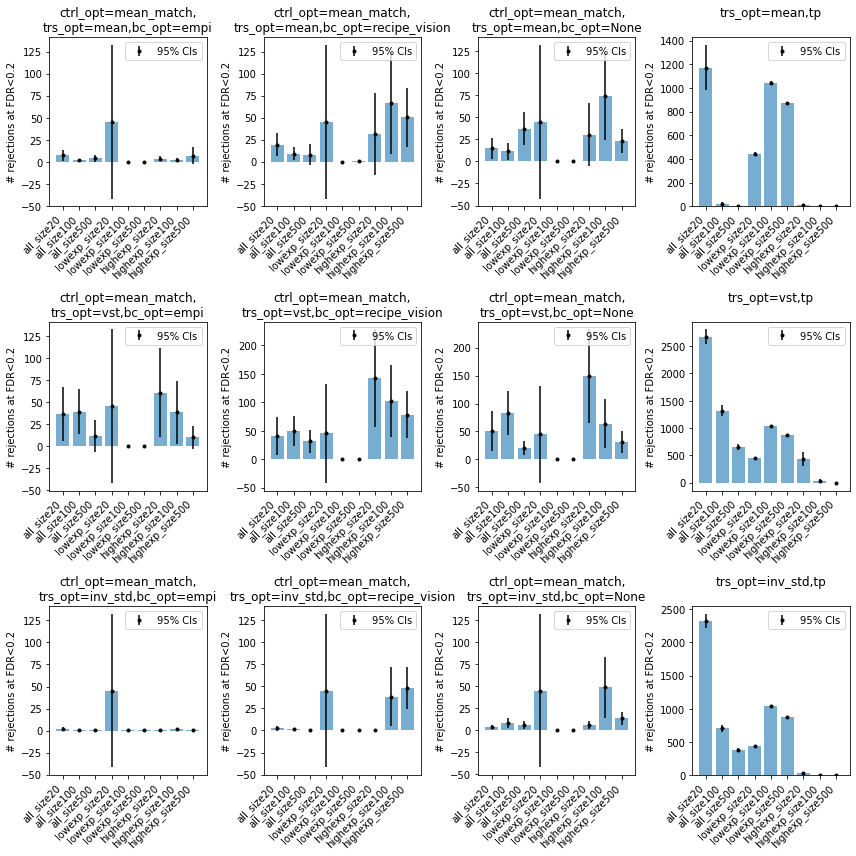

In [11]:
trait_list = ['all_size20', 'all_size100', 'all_size500',
              'lowexp_size20', 'lowexp_size100', 'lowexp_size500',
              'highexp_size20', 'highexp_size100', 'highexp_size500']
md_list = ['ctrl_opt=mean_match,trs_opt=mean,bc_opt=empi',
           'ctrl_opt=mean_match,trs_opt=mean,bc_opt=recipe_vision',
           'ctrl_opt=mean_match,trs_opt=mean,bc_opt=None',
           'trs_opt=mean,tp',
           'ctrl_opt=mean_match,trs_opt=vst,bc_opt=empi',
           'ctrl_opt=mean_match,trs_opt=vst,bc_opt=recipe_vision',
           'ctrl_opt=mean_match,trs_opt=vst,bc_opt=None',
           'trs_opt=vst,tp',
           'ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=empi',
           'ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=recipe_vision',
           'ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None',
           'trs_opt=inv_std,tp',]

plt.figure(figsize=[12,12])
for i_mname,mname in enumerate(md_list):
    plt.subplot(3,4,i_mname+1)
    plt.bar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean'%x for x in trait_list]], alpha=0.6)
    plt.errorbar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean'%x for x in trait_list]],
                 yerr=1.96*df_plot.loc[mname, ['%s.se'%x for x in trait_list]], color='k', fmt='.', label='95% CIs')    
    plt.xticks(range(len(trait_list)), trait_list, rotation='45', ha='right')
    plt.ylabel('# rejections at FDR<0.2')
    plt.title(mname[0:20]+'\n'+mname[20:])
    plt.legend()
plt.tight_layout()
plt.show()
#     break

### Target appraoch

In [21]:
# Obtain TRS: This takes a lot of time.
from itertools import product
null_trait_list = list(dic_nullset.keys())
start_time = time.time()
dic_trs={}

for trait in null_trait_list:
    i_rep = int(trait.split(';')[-1].replace('rep',''))
    if i_rep > 20:
        continue

    term='%s;ctrl_opt=%s,trs_opt=%s,bc_opt=%s'%(trait,ctrl_opt,trs_opt,bc_opt)
    md.score_cell(data_facs_ct, dic_nullset[trait], suffix='', 
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                  n_ctrl=10, n_genebin=200, 
                  return_list=['trs_ep'], verbose=False)
    dic_trs[term] = data_facs_ct.obs['trs_ep'].values.copy()
    print('# %-50s time=%0.1fs'%(term,time.time()-start_time))

# all_size20;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=6.8s
# all_size20;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=13.6s
# all_size20;rep2;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=20.4s
# all_size20;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=27.2s
# all_size20;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=34.0s
# all_size20;rep5;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=40.7s
# all_size20;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=47.7s
# all_size20;rep7;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=54.5s
# all_size20;rep8;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=61.1s
# all_size20;rep9;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=67.9s
# all_size20;rep10;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=74.8s
# all_size20;rep11;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=81.5s
# all_size20;rep12;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=88.

# lowexp_size100;rep19;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=767.1s
# lowexp_size100;rep20;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=773.7s
# lowexp_size500;rep0;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=780.3s
# lowexp_size500;rep1;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=786.9s
# lowexp_size500;rep2;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=793.6s
# lowexp_size500;rep3;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=800.2s
# lowexp_size500;rep4;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=806.8s
# lowexp_size500;rep5;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=813.5s
# lowexp_size500;rep6;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=820.1s
# lowexp_size500;rep7;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=826.7s
# lowexp_size500;rep8;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=833.3s
# lowexp_size500;rep9;ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None time=839.9s
# lowexp_size5

In [22]:
md_list = list(set([x.split(';')[2] for x in dic_trs.keys() if 'tp' not in x]))
md_list = list(set([x.split(';')[2] for x in dic_trs.keys()]))
md_list.sort()
trait_list = list(set([x.split(';')[0] for x in dic_trs.keys()]))
trait_list.sort()
df_plot = pd.DataFrame(columns=['%s.mean'%x for x in trait_list] + ['%s.se'%x for x in trait_list] + 
                               ['%s.list'%x for x in trait_list],
                       index=md_list, data=-1)
for trait in trait_list:
    for mname in md_list:
        v_nrej = []
        for term in [x for x in dic_trs.keys() if (x.split(';')[0]==trait)&(x.split(';')[2]==mname)]:
            v_p = dic_trs[term]
            v_fdr = multipletests(v_p, method='fdr_bh')[1]
            v_nrej.append((v_fdr<0.2).sum())
        v_nrej = np.array(v_nrej)
        df_plot.loc[mname, '%s.mean'%trait] = v_nrej.mean()
        df_plot.loc[mname, '%s.se'%trait] = v_nrej.std()/np.sqrt(v_nrej.shape[0])
        df_plot.loc[mname, '%s.list'%trait] = ','.join(['%d'%x for x in v_nrej])
        print(trait, mname)

all_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
all_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
all_size500 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
highexp_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
highexp_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
highexp_size500 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
lowexp_size100 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
lowexp_size20 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None
lowexp_size500 ctrl_opt=mean_match,trs_opt=inv_std,bc_opt=None


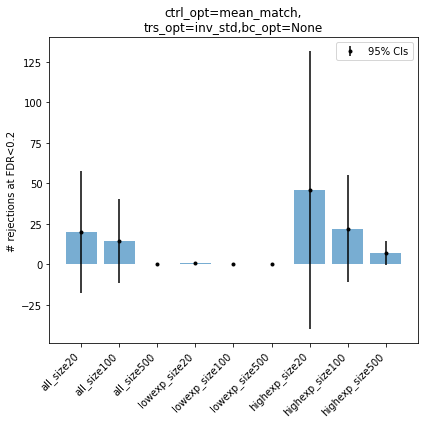

In [30]:
trait_list = ['all_size20', 'all_size100', 'all_size500',
              'lowexp_size20', 'lowexp_size100', 'lowexp_size500',
              'highexp_size20', 'highexp_size100', 'highexp_size500']

plt.figure(figsize=[6,6])
mname = md_list[0]
plt.bar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean'%x for x in trait_list]], alpha=0.6)
plt.errorbar(range(len(trait_list)), df_plot.loc[mname, ['%s.mean'%x for x in trait_list]],
             yerr=1.96*df_plot.loc[mname, ['%s.se'%x for x in trait_list]], color='k', fmt='.', label='95% CIs')
plt.xticks(range(len(trait_list)), trait_list, rotation='45', ha='right')
plt.ylabel('# rejections at FDR<0.2')
plt.title(mname[0:20]+'\n'+mname[20:])
plt.legend()
plt.tight_layout()
plt.show()
#     break

### Old code 